In [1]:
# imports
import pandas as pd
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

# transformers
from torchvision import transforms
from skimage.transform import rescale, resize, downscale_local_mean

# dataset imports
import os
import torch
import torch.utils.data
import torchvision

# model imports
import copy

In [2]:
# Load data 
X = pd.read_csv('../input/image_subset/subset_train.csv')
X.Label = X['Label'].astype('int')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3511 non-null   object
 1   Label   3511 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 41.3+ KB


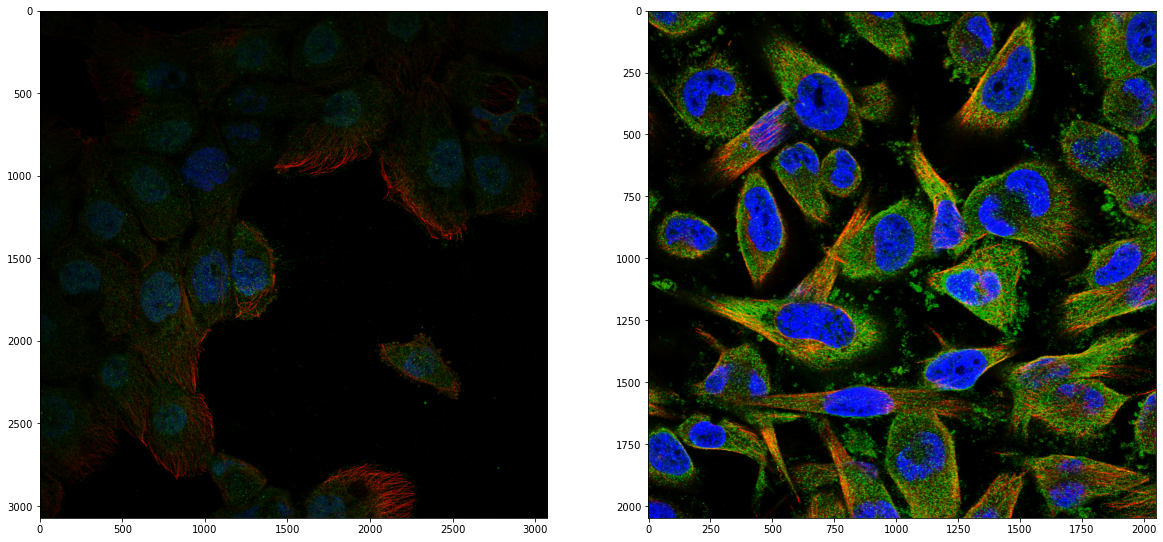

In [3]:
# view a couple RGBY-RGB converted images

SAVE_DIR = '../input/image_subset/image/'
rand = random.sample(sorted(X.ID), 2)
fig, ax = plt.subplots(1,2, figsize=(20,50))
ax[0].imshow(Image.open(SAVE_DIR+rand[0]+'.png'))
ax[1].imshow(Image.open(SAVE_DIR+rand[1]+'.png'))
plt.show()

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # check output size is 
                                                     # right format
        self.output_size = output_size

    def __call__(self, sample):
        
        imgs, target = sample['image'], sample['target']

        for i in range(len(imgs)):
            w, h = imgs[i].size 

            if isinstance(self.output_size, int):
                if h > w:
                    new_h, new_w = self.output_size * h / w, self.output_size
                else:
                    new_h, new_w = self.output_size, self.output_size * w / h
            else:
                new_h, new_w = self.output_size

            new_h, new_w = int(new_h), int(new_w)

            #resize iamge
            imgs[i] = imgs[i].resize((new_h, new_w))
        return {'image': imgs, 'target': target}

    
class split_mask(object):
    """Takes in PIL image of original image and Mask.
        Tiles Image according to desired size
        Padding could be a good idea
    """
    def __init__(self, tile_size):
        assert isinstance(tile_size, (int))
        self.tile_size = tile_size
        
        
    def tiled_img(self, img, box):
        """
        Find center of box. Crop the image using PIL
        at center, using desired tile size.
        """
        # (xmax-xmin) / 2 , (ymax - ymin) /2
        center = ( (box[2]-box[0])/2, (box[3]-box[1])/2 )
        
#         # Setting the points for cropped image
#         left = int(center[0] - self.tile_size/2)
#         top = int(center[1] + self.tile_size/2)
#         right = left + self.tile_size
#         bottom = top + self.tile_size
        left = box[0]
        top = box[1]
        right = box[2]
        bottom = box[3]
        # return crop using PIL 
        return(img.crop((left, top, right, bottom)))
        
        
    def __call__(self, sample):
        img, target = sample['image'], sample['target']
        
        # load target
        mask = target['masks']
        # convert to array for individual segments
        mask = np.array(mask)
        # split into different segmentations
        obj_ids = np.unique(mask)
        # 0 is background, get rid
        obj_ids = obj_ids[1:]
        
        # split color-encoded mask into
        # a set of binary masks
        
        masks = mask == obj_ids[:, None, None] # HOW DOES THIS WORK
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
         
        # list of tiled imgs
        tiles = list()
        for box in boxes:
            tiles.append(self.tiled_img(img, box))
             
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # define target
        imgs = tiles
        
        def encode_label(label):
            """
            Input Label (tensor single value)
            Output Labels (tensor of shape 3)
            To be used in loss function
            """
            arr = np.zeros(3)
            arr[label] = 1
            return(torch.from_numpy(arr))

        
        
        # convert to tensor
        target['labels'] = [encode_label(target['labels']) for i in range(num_objs)]
        
        return {'image': imgs, 'target': target}
    
    
class ImageToTensor(object):
    """Custom to tensor class, does not accept dictionary."""

    def __call__(self, sample):
        imgs, target = sample['image'], sample['target']
        # torch image: C X H X W
        for i in range(len(imgs)):
            imgs[i] = transforms.ToTensor()(imgs[i])
        return {'image': imgs, 'target': target}


In [5]:
class HPAImageDataset(object):
    
    
    def __init__(self, root, transforms, labels):
        self.root = root
        self.transforms = transforms
        # sort in order to make sure they
        # are aligned
        self.labels = labels # dictionary {'ID': 'label'}
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'image'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'mask'))))
                          
                          
    def __len__(self):
        return(len(self.imgs))
                          
    
    def __getitem__(self, idx):
        # load images and masks for idx
        img_path = os.path.join(self.root, "image", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask", self.masks[idx])
        # open img in PIL
        img = Image.open(img_path)
        # load mask
        mask = Image.open(mask_path)
        
        #define target
        target = {}
        # set image id and mask
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        target["masks"] = mask
        # label there is only one class in picture
        # this is how the dataset is defined
        label = self.labels[os.path.basename(img_path[:-4])]
        target["labels"] = label
        
        if self.transforms is not None:
            # torchvision compose only accepts single input
            sample = self.transforms({'image': img, 'target': target})
            imgs, targets = sample['image'], sample['target']
        # choose what returning 
        imgs = imgs
        annotations = {
            'image_id': targets['image_id'],
            'labels': targets['labels'],
        }
        return(imgs, annotations)  

In [6]:
# define labels as a dictionary
map_labels={
    0: 0,
    14: 1,
    16: 2
}

labels = dict(zip(X.ID, X.Label.apply(lambda x: map_labels[x])))

In [7]:
# define transforms
def get_transform():
    custom_transforms = [split_mask(224), Rescale((224,224)),
                        ImageToTensor()]
    return torchvision.transforms.Compose(custom_transforms)

ROOT_DIR = '../input/image_subset/'
# create own Dataset
transformed_dataset = HPAImageDataset(root=ROOT_DIR,
                          transforms=get_transform(),
                          labels=labels,
                          )

In [8]:
def collate_fn(batch):
    anno = []
    tiles = []
    for b in batch:
        for label in b[1]['labels']:
            anno.append(label)
        for tile in b[0]:
            tiles.append(tile)
    return tuple(zip(tiles, anno))

In [9]:
# set train val split
split = int(0.8 * len(transformed_dataset))

# batch size
batch_s = 1

# train dataset & dataloader
dataset_train = torch.utils.data.Subset(transformed_dataset, 
                                        list(range(0,split)))

train_loader = torch.utils.data.DataLoader(dataset_train,
                                          batch_size=batch_s,
                                          shuffle=True, collate_fn=collate_fn)

# test dataset & dataloader
dataset_test = torch.utils.data.Subset(transformed_dataset,
                                     list(range(split, len(transformed_dataset))))
test_loader = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=1,
                                          shuffle=False, collate_fn=collate_fn)
print(len(dataset_train))
print(len(dataset_test))

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

2808
703


This Image has label: tensor([0., 0., 1.], dtype=torch.float64)


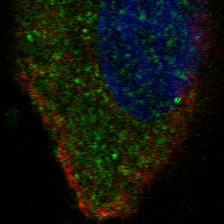

In [10]:
single_batch = next(iter(train_loader))

print('This Image has label: {}'.format(single_batch[0][1]))
# sigle_batch[img ro label][img_n][tile_n]
(transforms.ToPILImage(mode='RGB')(single_batch[0][0]))

In [14]:
# labels loss reshape
torch.reshape(single_batch[0][1], (1,3))

tensor([[0., 0., 1.]], dtype=torch.float64)

In [17]:
# number of tiles
len(single_batch)

7

The output is as follow:

sample_batched= list(tile, label)

# Model Training

[Resnet50 Pytorch Kaggle](https://www.kaggle.com/gxkok21/resnet50-with-pytorch)

In [18]:
if len(train_loader) * batch_s == len(dataset_train):
    print('Setup is correct')

Setup is correct


In [19]:
# model = torchvision.models.resnet50(pretrained=True)
model = torchvision.models.resnet50()

# output features to 3 classification
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=3
    ),
    torch.nn.Sigmoid()
)

In [20]:
# Config

USE_GPU = True
EPOCHS = 1

In [23]:
if USE_GPU:
    model = model.cuda() # Should be called before instantiating optimizer according to docs: https://pytorch.org/docs/stable/nn.html

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# logs
log_loss = list()
log_acc = list()

for i in range(EPOCHS):
    
    for phase in ["train", "test"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        
        samples = 0
        loss_sum = 0
        correct_sum = 0
        
        for j, batch in enumerate(dataloaders[phase]):
            
            # for tiles in batch
            for k in range(len(batch)):
                
                # define X and y
                X = batch[k][0].unsqueeze(0) # model requires tensor stack
                                             # [N, C, W, H]
                labels = torch.reshape(batch[k][1], (1,3))
                                            # [N, 3]
                
                if USE_GPU:
                    X = X.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    y = model(X)
                    loss = criterion(
                        y, 
                        labels.float()
                    )

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                    loss_sum += loss.item() * 1 # always one input to model
                    samples += 1 # always one input into model
                    num_corrects = torch.sum((y >= 0.5).float() == labels.float())
                    correct_sum += num_corrects
                
            # Print image statistics every 100 images
            if j % 100 == 0 and phase == "train":
                loss = float(loss_sum) / float(samples)
                acc = float(correct_sum) / float(samples*3) # 3 classes per sample

                # log values (probably a PyTorch way to do this)
                log_loss.append(loss)
                log_acc.append(acc)

                print("{}:{} - loss: {}, acc: {}".format(
                    i, 
                    j, 
                    loss, 
                    acc
                ))
            
        # Print epoch statistics
        epoch_acc = float(correct_sum) / float(samples*3)
        epoch_loss = float(loss_sum) / float(samples)
        print("epoch: {} - {} loss: {}, {} acc: {}".format(i + 1, phase, epoch_loss, phase, epoch_acc))
        
        # Deep copy the model
        if phase == "test" and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "resnet50.pth")

0:0 - loss: 0.854922042006538, acc: 0.3333333333333333
0:100 - loss: 0.6436403390303048, acc: 0.6502057613168725
0:200 - loss: 0.6317677650258074, acc: 0.663568893191352
0:300 - loss: 0.6344593608441372, acc: 0.6591943657133041
0:400 - loss: 0.625991669644099, acc: 0.6657679345209436
0:500 - loss: 0.6242520430141532, acc: 0.6699805825242718
0:600 - loss: 0.6218275535715962, acc: 0.6736062027458288
0:700 - loss: 0.623102585538098, acc: 0.6726792129707191
0:800 - loss: 0.6232916863683815, acc: 0.6707731380697936
0:900 - loss: 0.6213635145053937, acc: 0.6728297235428773
0:1000 - loss: 0.6220469081088755, acc: 0.6724755311530198
0:1100 - loss: 0.6215409956808171, acc: 0.6717693258672096
0:1200 - loss: 0.6182060163758658, acc: 0.6746086898970847
0:1300 - loss: 0.6186802446568361, acc: 0.6732565029935226
0:1400 - loss: 0.6187542242818728, acc: 0.6727961726114348
0:1500 - loss: 0.6143704340031692, acc: 0.6767922879313542
0:1600 - loss: 0.6159297624099788, acc: 0.675626170703002
0:1700 - loss:

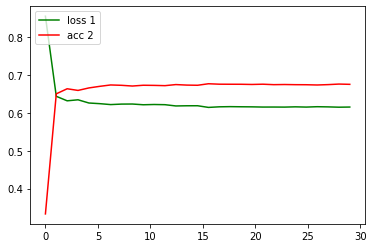

In [27]:
# plot loss and acc throughout
fig, ax = plt.subplots()
axis_x = np.linspace(0, len(log_loss), len(log_loss))
ax.plot(axis_x , log_loss, color = 'green', label = 'loss 1')
ax.plot(axis_x , log_acc, color = 'red', label = 'acc 2')
ax.legend(loc = 'upper left')
plt.show()